## 로지스틱 활용 : 

부도점수 계산 --> 부도 정의  --> 로지스틱 회귀 모델 학습

In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Windows에서 한글이 잘 보이는 기본 폰트 설정 (예: 'Malgun Gothic')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 음수 부호 깨짐 방지

C:\Users\JYB\AppData\Local\Temp\ipykernel_20112\1664479204.py:26: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


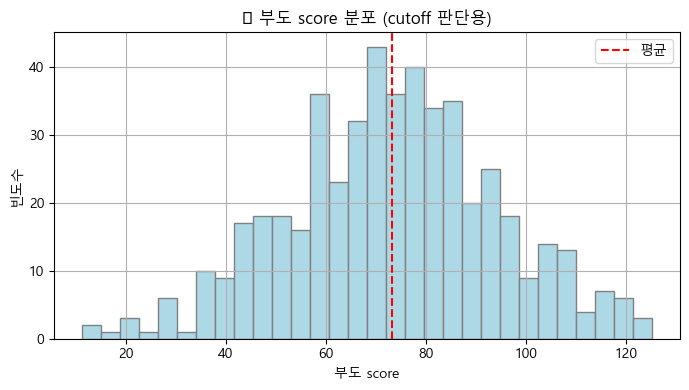

count    500.000000
mean      73.207244
std       20.965054
min       11.270137
25%       59.244367
50%       73.533016
75%       86.652265
max      125.087594
Name: score, dtype: float64

In [6]:
# 1. 시뮬레이션 데이터 생성 (score 분포만 확인)
np.random.seed(42)
n = 500

data = pd.DataFrame({
    "신용점수": np.random.normal(650, 50, n),
    "부채비율": np.random.uniform(0.1, 1.0, n),
    "대출금액": np.random.normal(100_000_000, 30_000_000, n),
})

# 2. 부도 점수 계산
data["score"] = (0.003 * (700 - data["신용점수"]) +
                 3.0 * data["부채비율"] +
                 0.0000007 * data["대출금액"] +
                 np.random.normal(0, 0.5, n))

# 3. score 분포 시각화하여 적절한 cutoff 찾기
plt.figure(figsize=(7, 4))
plt.hist(data["score"], bins=30, color='lightblue', edgecolor='gray')
plt.axvline(data["score"].mean(), color='red', linestyle='--', label='평균')
plt.title("📊 부도 score 분포 (cutoff 판단용)")
plt.xlabel("부도 score")
plt.ylabel("빈도수")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# score 분포가 확인되면, 그에 맞춰 cutoff 설정 후 다시 실행 가능
score_stats = data["score"].describe()
score_stats


### 1. cutoff 기준으로 부도 여부 정의 (score > 85 → 부도)

C:\Users\JYB\AppData\Local\Temp\ipykernel_20112\406455866.py:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


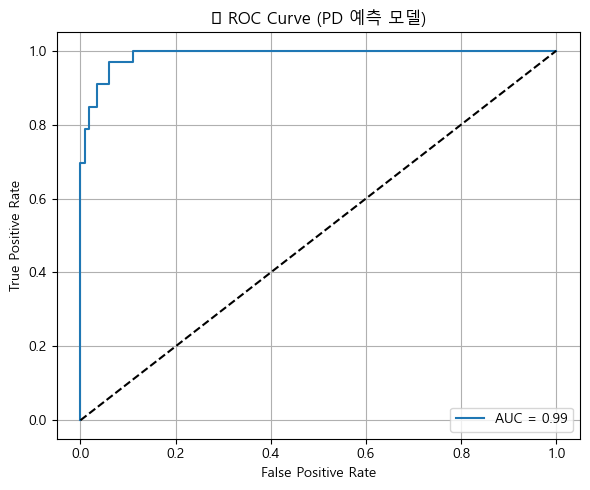

ModuleNotFoundError: No module named 'ace_tools'

In [7]:

cutoff = 85
data["부도여부"] = (data["score"] > cutoff).astype(int)

# 2. 입력 변수 및 타겟 분리
X = data[["신용점수", "부채비율", "대출금액"]]
y = data["부도여부"]

# 3. 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. 로지스틱 회귀 모델 학습
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 5. 예측 및 결과 정리
y_pred_proba = model.predict_proba(X_test)[:, 1]
data_test = X_test.copy()
data_test["예측 PD"] = y_pred_proba
data_test["실제 부도"] = y_test.values

# 6. ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve (PD 예측 모델)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

import ace_tools as tools; tools.display_dataframe_to_user(name="PD 예측 결과표", dataframe=data_test.head(10).round(3))


In [8]:
# 기대손실(EL) 계산을 위한 가정
# LGD, EAD 값을 간단히 시뮬레이션으로 생성

np.random.seed(42)
data_test["LGD"] = np.random.uniform(0.3, 0.6, len(data_test))       # 회수율 반영 손실률 (30~60%)
data_test["EAD"] = np.random.normal(100_000_000, 20_000_000, len(data_test))  # 노출액 (EAD), 평균 10억

# 기대손실 (Expected Loss) 계산
data_test["EL"] = data_test["예측 PD"] * data_test["LGD"] * data_test["EAD"]

# 상위 10개만 보기 좋게 출력
el_output = data_test[["예측 PD", "LGD", "EAD", "EL", "실제 부도"]].head(10).round({
    "예측 PD": 3,
    "LGD": 2,
    "EAD": 0,
    "EL": 0
})

import ace_tools as tools; tools.display_dataframe_to_user(name="기대손실(EL) 계산표", dataframe=el_output)


ModuleNotFoundError: No module named 'ace_tools'

In [9]:
el_output.style.format({'EAD': '{:,.0f}', 'EL': '{:,.0f}'})


,예측 PD,LGD,EAD,EL,실제 부도
361,0.014000,0.410000,"96,152,781","548,676",0
73,0.000000,0.590000,"106,030,947",10,0
374,0.213000,0.520000,"99,305,765","10,973,524",1
155,0.452000,0.480000,"76,626,439","16,617,297",0
104,0.993000,0.350000,"122,856,456","42,299,484",1
394,0.022000,0.350000,"115,038,661","881,490",0
377,0.002000,0.320000,"115,820,639","71,328",0
124,0.135000,0.560000,"81,812,251","6,197,186",0
68,0.006000,0.480000,"128,055,886","341,549",0
450,0.000000,0.510000,"71,962,979",0,0


In [10]:
# 기대외손실(Unexpected Loss, UL) 계산 포함

# 기존 데이터 활용
# 기대손실 EL = PD × LGD × EAD (이미 계산됨)

# 기대외손실 UL = sqrt[ PD × LGD^2 × EAD^2 - EL^2 ]
# 단, 이론적으로는 분산기반으로 계산되며, 간단화된 계산 예로 아래 사용
data_test["UL"] = np.sqrt(
    data_test["예측 PD"] * (data_test["LGD"] ** 2) * (data_test["EAD"] ** 2) - data_test["EL"] ** 2
)

# 음수가 나올 수 있으므로 UL 음수 제거 (계산상 오류 대비)
data_test["UL"] = data_test["UL"].apply(lambda x: x if x > 0 else 0)

# 상위 10개만 출력
el_ul_output = data_test[["예측 PD", "LGD", "EAD", "EL", "UL", "실제 부도"]].head(10).round({
    "예측 PD": 3,
    "LGD": 2,
    "EAD": 0,
    "EL": 0,
    "UL": 0
})

el_ul_output


,예측 PD,LGD,EAD,EL,UL,실제 부도
361,0.014,0.41,96152781.0,548676.0,4631828.0,0
73,0.000,0.59,106030947.0,10.0,24582.0,0
374,0.213,0.52,99305765.0,10973524.0,21114111.0,1
155,0.452,0.48,76626439.0,16617297.0,18290671.0,0
104,0.993,0.35,122856456.0,42299484.0,3608421.0,1
394,0.022,0.35,115038661.0,881490.0,5864317.0,0
377,0.002,0.32,115820639.0,71328.0,1617793.0,0
124,0.135,0.56,81812251.0,6197186.0,15666636.0,0
68,0.006,0.48,128055886.0,341549.0,4570766.0,0
450,0.000,0.51,71962979.0,0.0,2150.0,0


In [11]:
# 총 기대손실 및 기대외손실 계산
total_el = data_test["EL"].sum()
total_ul = data_test["UL"].sum()

# 부도/비부도 그룹별 평균 비교
grouped_stats = data_test.groupby("실제 부도")[["예측 PD", "EL", "UL"]].mean().round(0)
grouped_stats.index = ["정상(0)", "부도(1)"]

# 총합 결과 저장
summary = pd.DataFrame({
    "총 기대손실 (원)": [total_el],
    "총 기대외손실 (원)": [total_ul]
}).round(0)

summary, grouped_stats


(     총 기대손실 (원)  총 기대외손실 (원)
 0  1.755433e+09  980212429.0,
        예측 PD          EL         UL
 정상(0)    0.0   3381110.0  5950522.0
 부도(1)    1.0  41207376.0  8606102.0)